In [1]:
import os
print(os.listdir('../input'))

['brain-tumor-classification-mri']


In [2]:
import matplotlib.pyplot as plt 
import matplotlib.colors
import numpy as np 
import pandas as pd 
import seaborn as sns 
import cv2 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, InputLayer, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm 
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.metrics import classification_report ,confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image 
from warnings import filterwarnings 

2024-09-08 08:57:07.994851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 08:57:07.994980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 08:57:08.127194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train =[]
Y_train =[] 
image_size =150 
for i in labels : 
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        img = img / 255.0  # Normalize the image
        X_train.append(img) 
        Y_train.append(i)

for i in labels : 
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size)) 
        img = img / 255.0  # Normalize the image
        X_train.append(img) 
        Y_train.append(i) 
X_train = np.array(X_train) 
Y_train = np.array(Y_train) 

100%|██████████| 74/74 [00:00<00:00, 93.13it/s] 


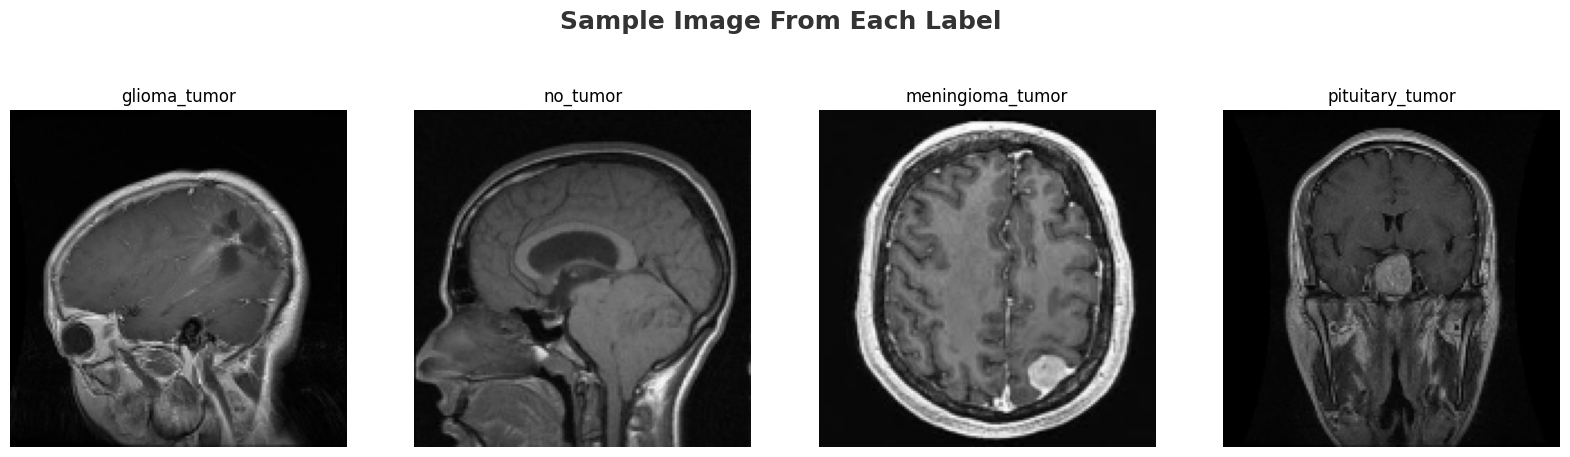

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if Y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(Y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [5]:
X_train , Y_train = shuffle(X_train ,Y_train,random_state=101)

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.1,random_state=101)

In [7]:
X_train.shape

(2937, 150, 150, 3)

In [8]:
X_test.shape

(327, 150, 150, 3)

In [9]:
label_encoder = LabelEncoder() 
y_train_num = label_encoder.fit_transform(Y_train)
y_test_num = label_encoder.fit_transform(Y_test)

Y_train = tf.keras.utils.to_categorical(y_train_num)
Y_test = tf.keras.utils.to_categorical(y_test_num)

In [10]:
Y_test

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [11]:

n_samples, height, width, channels = X_train.shape

# Reshape X_train to (n_samples, height * width * channels)
X_train_reshaped = X_train.reshape(n_samples, -1)

smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(X_train_reshaped, Y_train)

# reshape X_resampled back to the original dimensions
X_resampled = X_resampled.reshape(-1, height, width, channels)

print(X_resampled.shape)
print(Y_resampled.shape)

(3364, 150, 150, 3)
(3364, 4)


In [12]:

#  Y_train and Y_resampled are one-hot encoded:
Y_train_labels = np.argmax(Y_train, axis=1)
Y_resampled_labels = np.argmax(Y_resampled, axis=1)

# Count occurrences
train_class_counts = Counter(Y_train_labels)
resampled_class_counts = Counter(Y_resampled_labels)

print("Original training class distribution:", train_class_counts)
print("Resampled class distribution:", resampled_class_counts)

Original training class distribution: Counter({1: 841, 0: 833, 3: 814, 2: 449})
Resampled class distribution: Counter({0: 841, 2: 841, 3: 841, 1: 841})


**Building CNN Model**

In [16]:

model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Convolutional Layer 4
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,815,428 (26.00 MB)

 Trainable params: 6,814,468 (26.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:

#model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, verbose=True)

history = model.fit(X_resampled, Y_resampled, batch_size=64, epochs=100)

Epoch 1/100
 5/53 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3818 - loss: 7.1213

W0000 00:00:1725786198.728488     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.5512 - loss: 4.4402
Epoch 2/100
 3/53 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7726 - loss: 0.5598

W0000 00:00:1725786203.965152     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7596 - loss: 0.6298
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8119 - loss: 0.4741
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8525 - loss: 0.3855
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8515 - loss: 0.3703
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9019 - loss: 0.2794
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9163 - loss: 0.2224
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9133 - loss: 0.2217
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9279 - loss: 0.1940
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9421 - loss: 0.1640
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9457 - loss: 0.1557
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9518 - loss: 0.1490
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy

In [18]:
# Predict the val model
Y_pred = model.predict(X_test)
Y_test_labels = np.argmax(Y_test, axis=1)

# Convert model predictions to class labels
Y_pred_labels = np.argmax(Y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(Y_test_labels, Y_pred_labels)
print('Test Accuracy = %.4f' % accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Test Accuracy = 0.9235


W0000 00:00:1725786395.161401     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
print("Classification Report:\n",classification_report(Y_test_labels, Y_pred_labels))

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Define the custom color map
custom_colors = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
cm = confusion_matrix(Y_test_labels, Y_pred_labels)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.10,alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure
plt.savefig('CM CNN-2.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
#fig, ax = plt.subplots(1, 2, figsize=(10, 5), facecolor='white')

# Plot training and validation accuracy
#ax[0].plot(history.history['accuracy'])
#ax[0].plot(history.history['val_accuracy'])
#ax[0].set_title('Model Accuracy')
#ax[0].set_xlabel('Epoch')
#ax[0].set_ylabel('Accuracy')
#ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss
#ax[1].plot(history.history['loss'])
#ax[1].plot(history.history['val_loss'])
#ax[1].set_title('Model Loss')
#ax[1].set_xlabel('Epoch')
#ax[1].set_ylabel('Loss')
#ax[1].legend(['Train', 'Validation'], loc='upper right')

# Save the figure
#plt.savefig('plot CNN-2.png', dpi=300, bbox_inches='tight')

#plt.tight_layout()
#plt.show()

In [ ]:
model.save('model.h5')